# Analysis

In [34]:
import pandas as pd
import plotnine as pn

In [35]:
# Load data

params = [
    0, 1, 2, 4, 8, 16, # nosofsky
    # 0.1, 0.2, 0.5, 0.6, 0.75, 1, 2, 3, 5, 1000 # exp
]

# Learned
dynamic = "reinforcement_learning"
# dynamic = "replicator_dynamic"

# num_trials = 10
num_trials = 100

# similarity = "nosofsky"
similarity = "nosofsky_normed"
# similarity = "exp"
# similarity = "exp_normed"

distortion = "squared_dist"
# distortion = "abs_dist"

out = "multirun"
# out = "outputs"

# trajectory = True
trajectory = False


#############################################################################
# Below three saved in outputs, not multirun

# Pareto frontier
curve_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/curve_points.csv"

# Counterpart points
counterpart_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/counterpart_points.csv"

# Explored hypothetical systems
sampled_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/sampled_points.csv"

#############################################################################
# Typically saved in multirun
# Simulation points
param_fns = {
    f"{float(param)}":f"/Users/nathanielimel/lps/projects/rdsg/{out}/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics={dynamic}/num_trials={num_trials}/sim_param={param}/simulation_points.csv"
    for param in params
}

variant_fns = {key: val.replace("simulation_points", "variants_points") for key, val in param_fns.items()}

if trajectory:
    param_fns = {key: val.replace("simulation_points", "mean_points") for key, val in param_fns.items()}



In [36]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
counterpart_data = pd.read_csv(counterpart_fn)
sampled_data = pd.read_csv(sampled_fn)

simulation_dataframes = {
    k: pd.read_csv(param_fns[k]) for k in param_fns
}

variant_dataframes = {
    k: pd.read_csv(variant_fns[k]) for k in variant_fns
}

In [37]:
param_names = {"exp": "beta", "nosofsky": "alpha"}
for name in param_names:
    if name in similarity:
        param_name = param_names[name]

# combine simulation dataframes
for key in simulation_dataframes:
    df = simulation_dataframes[key]
    df[param_name] = key # use string for category

sim_data = pd.concat(simulation_dataframes.values())
sim_data

,rate,distortion,alpha
0,3.275276,0.048496,0.0
1,2.777001,10.416543,0.0
2,2.704034,1.445759,0.0
3,2.882935,1.331747,0.0
4,3.087389,1.665824,0.0
...,...,...,...
95,0.022246,14.445306,16.0
96,0.015009,15.139953,16.0
97,0.025801,14.887824,16.0
98,0.017506,15.190406,16.0


In [38]:
# combine variant dataframes
# combine simulation dataframes
for key in variant_dataframes:
    df = variant_dataframes[key]
    df[param_name] = key # use string for category

variant_data = pd.concat(variant_dataframes.values())
variant_data

,rate,distortion,alpha
0,3.274847,14.218211,0.0
1,3.274316,19.386029,0.0
2,3.274335,9.620963,0.0
3,3.275224,5.243631,0.0
4,3.274327,20.793190,0.0
...,...,...,...
995,0.011293,16.851134,16.0
996,0.013819,16.687504,16.0
997,0.015228,16.803387,16.0
998,0.010813,16.944134,16.0


In [39]:
sim_data[param_name] = sim_data[param_name].astype(float)
sim_data[param_name] = sim_data[param_name].astype(int)
sim_data[param_name] = sim_data[param_name].astype(str)
counterpart_data[param_name] = counterpart_data[param_name].astype(float)
counterpart_data[param_name] = counterpart_data[param_name].astype(int)
counterpart_data[param_name] = counterpart_data[param_name].astype(str)

sim_data

,rate,distortion,alpha
0,3.275276,0.048496,0
1,2.777001,10.416543,0
2,2.704034,1.445759,0
3,2.882935,1.331747,0
4,3.087389,1.665824,0
...,...,...,...
95,0.022246,14.445306,16
96,0.015009,15.139953,16
97,0.025801,14.887824,16
98,0.017506,15.190406,16


In [40]:
# plot each language, with a unique color for each gamma

# hard to clean this up with pd.Categorical
if param_name == "alpha":
    counterpart_data = counterpart_data.assign(
            alpha=pd.Categorical(
                counterpart_data["alpha"], 
                categories=[str(param) for param in params]
            )
        )

    sim_data = sim_data.assign(
            alpha=pd.Categorical(
                sim_data["alpha"], 
                categories=[str(param) for param in params]
            )
        )
else:
    counterpart_data = counterpart_data.assign(
            beta=pd.Categorical(
                counterpart_data["beta"], 
                categories=[str(param) for param in params]
            )
        )

    sim_data = sim_data.assign(
            beta=pd.Categorical(
                sim_data["beta"], 
                categories=[str(param) for param in params]
            )
        )


# Language keys
sim_data["language"] = {"reinforcement_learning": "learned", "replicator_dynamic": "evolved"}[dynamic]
counterpart_data["language"] = "optimal counterpart"
all_data = pd.concat([counterpart_data, sim_data])

sampled_data["language"] = "hypothetical"
variant_data["language"] = "hypothetical"

# Trajectory keys
if trajectory:
    sim_data["time step"] = sim_data["round"]

counterpart_data


,rate,distortion,beta,alpha,language
0,3.321928,0.000000,1000.000000,0,optimal counterpart
1,1.862177,0.485048,1.000000,1,optimal counterpart
2,0.963131,1.822883,0.250000,2,optimal counterpart
3,0.057531,7.616357,0.062500,4,optimal counterpart
4,0.001560,8.380513,0.015625,8,optimal counterpart
5,0.000248,8.845957,0.003906,16,optimal counterpart


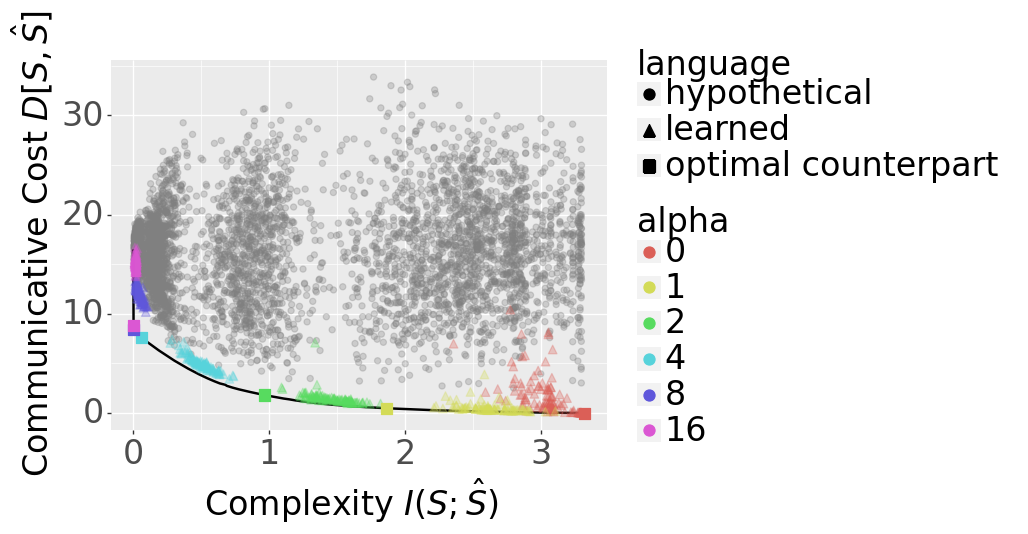

In [57]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # sampled langs
        # sampled_data,
        variant_data,
        pn.aes(shape="language"),
        color="gray",
        size=2,
        alpha=0.3,
    )
    + pn.geom_line(size=1) # pareto data                   
    + pn.geom_jitter( # simulation langs
        data=sim_data,
        mapping=pn.aes(
            color=param_name, 
            shape="language",
            ),
        alpha=0.3,
        size=3,
        # height=0.1,
    )
    + pn.geom_point( # theoretical bound langs last
        data=counterpart_data,
        mapping=pn.aes(
            color=param_name,
            shape="language",
            ),
        size=4,
    )    
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
    + pn.theme(text=pn.element_text(size=24))
)
print(plot)

In [58]:
# # Save plot (will overwrite!)

plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics={dynamic}/num_trials={num_trials}"
fn = plot_save_dir + f"/multiple_{param_name}.png"
plot.save(filename=fn, width=10, height=10, dpi=300)
print(fn)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion=squared_dist/similarity=nosofsky_normed/dynamics=reinforcement_learning/num_trials=100/multiple_alpha.png


/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion=squared_dist/similarity=nosofsky_normed/dynamics=reinforcement_learning/num_trials=100/multiple_alpha.png


## Plot trajectories

In [43]:
# Load data
mean_traj_fns = {
    key: val.replace("simulation_points", "mean_points") for key, val in param_fns.items()
}

mean_traj_dataframes = {
    k: pd.read_csv(mean_traj_fns[k]) for k in mean_traj_fns
}

# combine simulation dataframes
for key in mean_traj_dataframes:
    df = mean_traj_dataframes[key]
    df["alpha"] = key # use string for category

mean_traj_data = pd.concat(mean_traj_dataframes.values())
mean_traj_data = mean_traj_data.dropna() # unnecessary if all files were trajectories

mean_traj_data

,rate,distortion,round,alpha
0,0.007064,16.443802,0,0.0
1,0.007166,16.439747,1,0.0
2,0.007261,16.431988,2,0.0
3,0.007324,16.433375,3,0.0
4,0.007445,16.423548,4,0.0
...,...,...,...,...
99995,0.017970,15.072813,99995,16.0
99996,0.017970,15.072801,99996,16.0
99997,0.017970,15.072791,99997,16.0
99998,0.017970,15.072789,99998,16.0


In [44]:
mean_traj_data["alpha"] = mean_traj_data["alpha"].astype(float)
mean_traj_data["alpha"] = mean_traj_data["alpha"].astype(int)
mean_traj_data["alpha"] = mean_traj_data["alpha"].astype(str)

mean_traj_data = mean_traj_data.assign(
    alpha=pd.Categorical(
        mean_traj_data["alpha"],
        categories=[str(param) for param in params]
    )
)

mean_traj_data["language"] = {"reinforcement_learning": "learned", "replicator_dynamic": "evolved"}[dynamic]

mean_traj_data

,rate,distortion,round,alpha,language
0,0.007064,16.443802,0,0,learned
1,0.007166,16.439747,1,0,learned
2,0.007261,16.431988,2,0,learned
3,0.007324,16.433375,3,0,learned
4,0.007445,16.423548,4,0,learned
...,...,...,...,...,...
99995,0.017970,15.072813,99995,16,learned
99996,0.017970,15.072801,99996,16,learned
99997,0.017970,15.072791,99997,16,learned
99998,0.017970,15.072789,99998,16,learned


In [45]:
# Extract the final rounds

final_round = mean_traj_data["round"].max()
final_round_data = mean_traj_data[mean_traj_data["round"] == final_round]


In [29]:
# try latex for color

# r'$\sin (x)$'

final_round_data["$\alpha$"] = final_round_data["alpha"]
mean_traj_data["$\alpha$"] = mean_traj_data["alpha"]

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7169/224941030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


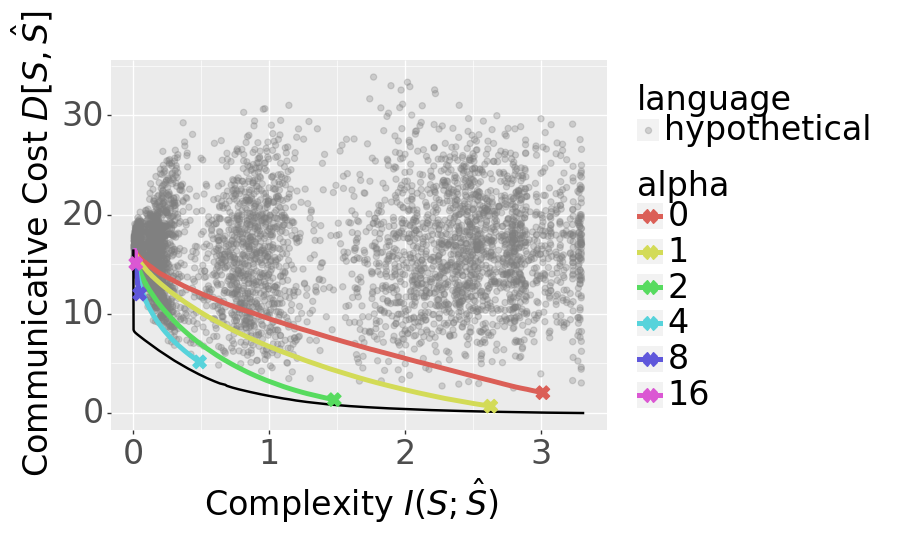

In [59]:
plot = (
    # Set data and the axes
    pn.ggplot(
            data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  # pareto data    
    + pn.geom_point(  # sampled langs
        # sampled_data,
        variant_data,
        pn.aes(shape="language"),
        color="gray",
        size=2,
        alpha=0.3,
    )
    + pn.geom_line(  # simulation langs
        data=mean_traj_data,
        mapping=pn.aes(color="alpha"),
        # shape="o",
        alpha=1.0,
        size=2,
    )
    + pn.geom_line(size=1) # pareto     
    + pn.geom_point(  # final langs
        data=final_round_data,
        mapping=pn.aes(color="alpha"),
        shape="X",
        alpha=1.0,
        size=5,
    )
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
    + pn.theme(text=pn.element_text(size=18))
)
print(plot)

In [60]:
# Save plot (will overwrite!)

plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics={dynamic}/num_trials={num_trials}"
fn = plot_save_dir + "/alpha_trajectories.png"
plot.save(filename=fn, width=10, height=10, dpi=300)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion=squared_dist/similarity=nosofsky_normed/dynamics=reinforcement_learning/num_trials=100/alpha_trajectories.png


# Perform statistical analyses

### Measure optimality

In [ ]:
# N.B.: The reason we need to copypaste this function is because it is sometimes more convenient to measure optimality all at once here, instead of running python script in a hydra sweep (if I forgot to)
import numpy as np
from scipy.spatial.distance import cdist

def measure_optimality(data: pd.DataFrame, curve_data: pd.DataFrame) -> np.ndarray:
    """Compute the min distance to any point on the frontier, for every point. Requires `data` to contain more than one row."""
    # get curve points as list of pairs
    pareto_points = np.array(list(curve_data[["rate", "distortion"]].itertuples(index=False, name=None)))
    points = np.array(list(data[["rate", "distortion"]].itertuples(index=False, name=None)))
    # N.B.: do not interpolate, so you don't measure high-dist random langs as more optimal than they are!

    # Measure closeness of each language to any frontier point
    distances = cdist(points, pareto_points)
    min_distances = np.min(distances, axis=1)

    # max complexity will be achieved by B-A    
    max_complexity = pareto_points[:, 0].max()
    # points may have higher cost than pareto max cost    
    max_cost = max(points[:,1].max(), pareto_points[:,].max())
    # max possible distance is sqrt( max_rate^2 + (max_distortion)^2 )
    max_distance = np.sqrt(max_cost**2 + max_complexity**2)

    # just use the max found distance? 
    # max_distance = np.max(min_distances)

    min_distances /= max_distance
    optimalities = 1 - min_distances
    return optimalities
    
    # return min_distances

In [ ]:
sim_data["optimality"] = measure_optimality(sim_data, curve_data)
variant_data["optimality"] = measure_optimality(variant_data, curve_data)
# sampled_data["optimality"] = measure_optimality(sampled_data, curve_data)


In [ ]:
display(sim_data.mean())
display(variant_data.mean())


In [ ]:
display(sim_data.min())
display(variant_data.min())
display(sampled_data.min())

### Show optimality in violin plots
*N.B.: need to change python interpreter to 'seaborn'!*

In [ ]:
# N.B.: good violin plots requires seaborn 0.12.2, which is incompatible with plotnine
import seaborn as sns
import matplotlib.pyplot as plt
plt.ion()
sns.set_theme()

In [ ]:

data = pd.concat([sim_data, variant_data])

violin = sns.catplot(
    data=data, y="alpha", x="optimality", hue="language", kind="violin", inner=None, split=False, cut=0, bw=.15, palette="pastel"
)

# violin.set(xlim=(None, None))

# sns.catplot(
#     data=tips, x="day", y="total_bill", hue="sex",
#     kind="violin", inner="stick", split=True, palette="pastel",
# )

plt.show()
# plt.savefig("rep_violin.png")

### be messy and load up rl data

In [ ]:
# load up rl data by hand, not from saved

# Simulation points
param_fns_rl = {
    f"{float(param)}":f"/Users/nathanielimel/lps/projects/rdsg/{out}/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics=reinforcement_learning/num_trials={num_trials}/sim_param={param}/simulation_points.csv"
    for param in params
}

variant_fns_rl = {key: val.replace("simulation_points", "variants_points") for key, val in param_fns.items()}


simulation_dataframes_rl = {
    k: pd.read_csv(param_fns_rl[k]) for k in param_fns_rl
}

variant_dataframes_rl = {
    k: pd.read_csv(variant_fns_rl[k]) for k in variant_fns_rl
}


# combine simulation dataframes
for key in simulation_dataframes_rl:
    df = simulation_dataframes_rl[key]
    df[param_name] = key # use string for category

sim_data_rl = pd.concat(simulation_dataframes_rl.values())
display(sim_data_rl)


# combine
for key in variant_dataframes_rl:
    df = variant_dataframes_rl[key]
    df[param_name] = key # use string for category

variant_data_rl = pd.concat(variant_dataframes_rl.values())
display(variant_data_rl)

In [ ]:
# more messiness

sim_data_rl["optimality"] = measure_optimality(sim_data_rl, curve_data)
variant_data_rl["optimality"] = measure_optimality(variant_data_rl, curve_data)


sim_data_rl[param_name] = sim_data_rl[param_name].astype(float)
sim_data_rl[param_name] = sim_data_rl[param_name].astype(str)


sim_data = sim_data.assign(
            alpha=pd.Categorical(
                sim_data["alpha"], 
                categories=[g for g in simulation_dataframes_rl.keys()]
            )
        )

sim_data_rl["language"] = "learned"
variant_data_rl["language"] = "hypothetical"

sim_data_rl

In [ ]:
# get violin for both
rep_data = pd.concat([sim_data, variant_data])
rl_data = pd.concat([sim_data_rl, variant_data_rl])
dynamics_data = pd.concat([rep_data, rl_data])

# change language to categorical to customize ordering
dynamics_data = dynamics_data.assign(
        language=pd.Categorical(
                dynamics_data["language"], 
                categories=["learned", "evolved", "hypothetical"]
            )
        )

In [ ]:

violin = sns.catplot(
    data=dynamics_data,
    x="alpha", y="optimality", 
    hue="language", 
    kind="violin", 
    inner=None, 
    split=False, 
    cut=0, 
    bw=.15, 
    palette="pastel",
    scale="width",
)
plt.show()

In [ ]:
dynamics_data = dynamics_data.assign(
        alpha=pd.Categorical(
                dynamics_data["alpha"], 
                categories=params
            )
        )

## Try plotnine for violins

In [ ]:
# want alpha to be floats again

values = {"learned": "orange", "evolved": "green", "hypothetical": "blue"}

plot = (
    # Set data and the axes
    pn.ggplot(
            data=dynamics_data, mapping=pn.aes(x="alpha", y="optimality")
    )
    + pn.geom_violin(
        data=dynamics_data,
        mapping=pn.aes(
            fill="language", 
            color="language", 
            ),
        scale="width",
        bw=0.005,
    )
    + pn.scale_color_manual(values=values)
    + pn.scale_fill_manual(values=values)
    + pn.xlab("Perceptual imprecision ($\\alpha$)")
    + pn.ylab("Optimality (Pareto-closeness)")
    + pn.theme_seaborn(context='paper')
    + pn.theme(text=pn.element_text(size=24))
)
print(plot)

In [ ]:
# save plot
fn = "optimality.png"
plot.save(filename=fn, width=10, height=10, dpi=300)

### other junk

In [ ]:
# what does hypothetical look like?
data = pd.concat([sim_data, variant_data])

sns.displot(data=data, x="rate", y="deviation from optimality", hue="language",)

In [ ]:
# save data for messing around later with plots

sim_data.to_csv("rl.csv", index=False)
# sampled_data.to_csv("explored.csv")
variant_data.to_csv("rl_variants.csv", index=False)


# sim_data.to_csv("rep_dyn.csv", index=False)
# variant_data.to_csv("rep_dyn_variants.csv", index=False)